In [1]:
import mxnet as mx
from mxnet import nd
from mxnet.gluon.model_zoo import vision
import tvm
import tvm.relay as relay
from tvm.contrib import graph_runtime 

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
from PIL import Image 

In [2]:
# download pre-trained model from mxnet model_zoo
block = vision.get_model('MobileNet1.0', pretrained=True)
# print(block.output.weight, '\n')
# print(block.summary)

In [3]:
# ImageNet Label
# Synset for converting the number of ImageNet classes to human vocabulary
synset_path = "/Users/Mac_Chen/Desktop/TVM/from_tvm_to_deeplearning/pre-trained_model/imagenet1000_clsid_to_human.txt"

with open(synset_path) as f:
    # text_labels = [' '.join(l.split()[1:]) for l in f]
    text_labels = eval(f.read())

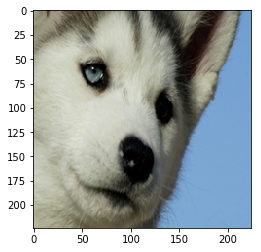

(224, 224, 3)


In [15]:
# test data
test_data_path = "/Users/Mac_Chen/Desktop/TVM/from_tvm_to_deeplearning/data/tst"
count = 0
img_list = []

img_paths = glob.glob(os.path.join(test_data_path, "*.JPEG"))
img_paths.sort()

for path in img_paths:
    count += 1
    if count > 1:
        break
    
    # Images under image files, either single channel (Black and White) or triple channel (RGB).
    # Unify the format of read images to prevent “ValueError: axes don't match array ”
    np_image = Image.open(path).convert("RGB").resize((256, 256))
    np_img = np_image.crop((16, 16, 240, 240))
    img_list.append(np.array(np_img))
    plt.imshow(np.array(np_img))
    plt.show()
print(img_list[0].shape)

In [16]:
def transform_image_mx(image):
    image = image.transpose((2, 0, 1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1))
    return (image.astype('float32') / 255 - rgb_mean) / rgb_std

def transform_image_np(image):
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, axis=0)
    rgb_mean = np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
    rgb_std = np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1))
    return (image.astype('float32') / 255 - rgb_mean) / rgb_std

## MXNet

In [19]:
start_time_mxnet = time.time()
prob_avg = 0
count = 0
for img in img_list:
    pred = block(nd.array(transform_image_np(img)))
    prob = mx.nd.softmax(pred)[0].asnumpy()

    idx = mx.nd.topk(pred, k=3)[0].astype('int').asnumpy().tolist()
    for i in range(3):
        print('With prob = %.5f, it contains %s' % (prob[idx[i]], text_labels[idx[i]]))
    prob_avg += prob[idx[0]]
    count += 1

# print('Average accuracy = %0.5f' % float(prob_avg / count))
print('Cost of time: %.5f sec' % (time.time() - start_time_mxnet))

With prob = 0.37079, it contains malamute, malemute, Alaskan malamute
With prob = 0.33235, it contains Siberian husky
With prob = 0.29388, it contains Eskimo dog, husky
Cost of time: 0.14503 sec


In [104]:
# start_time_mxnet = time.time()
# pred = block(nd.array(transform_image_np(np.array(np_img))))
# print('Cost of time: %.5f sec' % (time.time() - start_time_mxnet))
# prob = mx.nd.softmax(pred)[0].asnumpy()

# idx = mx.nd.topk(pred, k=3)[0].astype('int').asnumpy().tolist()
# for i in range(3):
#     print('With prob = %.5f, it contains %s' % (prob[idx[i]], text_labels[idx[i]]))

## TVM Relay

In [20]:
print('Relay: get model from mxnet')

img_ = transform_image_np(img_list[0])
print('img', img_.shape, 'type: ', type(img_))

shape_dict = {'data': img_.shape}
print('Block: {0}, Dict_shape: {1}'.format(type(block), type(shape_dict)))

print('Relay get mod from mxnet...')
mod, params = relay.frontend.from_mxnet(block, shape_dict)

print('Mod: {0}, Params: {1}'.format(type(mod), type(params)))
func = mod['main']
func = relay.Function(func.params, relay.nn.softmax(func.body), None, func.type_params, func.attrs)

# print(type(func.astext(show_meta_data=False)))
# print(func)
# print(type(params))
# print(params)

Relay: get model from mxnet
img (1, 3, 224, 224) type:  <class 'numpy.ndarray'>
Block: <class 'mxnet.gluon.model_zoo.vision.mobilenet.MobileNet'>, Dict_shape: <class 'dict'>
Relay get mod from mxnet...
Mod: <class 'tvm.ir.module.IRModule'>, Params: <class 'dict'>


In [21]:
print("Relay: build the graph")
# target = 'llvm'
target = tvm.target.create('llvm')
# target_host = 'cuda'
with relay.build_config(opt_level=3):
    graph, lib, params = relay.build(func, target, params=params)
    
print("Graph: {0}, lib: {1}, params: {2}".format(type(graph), type(lib), type(params)))
# print(graph)

Relay: build the graph


Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 224, 224), 'float32'), ('TENSOR', (32, 3, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('depthwise_conv2d_NCHWc.x86', ('TENSOR', (1, 32, 112, 112), 'float32'), ('TENSOR', (32, 1, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 112, 112), 'float32'), ('TENSOR', (64, 32, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('depthwise_conv2d_NCHWc.x86', ('TENSOR', (1, 64, 112

Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 28, 28, 8), 'float32'), ('TENSOR', (32, 32, 1, 1, 8, 8), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('depthwise_conv2d_NCHWc.x86', ('TENSOR', (1, 32, 28, 28, 8), 'float32'), ('TENSOR', (32, 1, 3, 3, 1, 8), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 16, 28, 28, 8), 'float32'), ('TENSOR', (32, 16, 1, 1, 8, 8), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('depthwise_conv2d

Graph: <class 'str'>, lib: <class 'tvm.runtime.module.Module'>, params: <class 'dict'>


/anaconda3/envs/gluon/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: legacy graph runtime behaviour of producing json / lib / params will be removed in the next release 
  


In [22]:
# print(lib)
# print(params)

In [24]:
print('Tvm: run the graph')
ctx = tvm.cpu(0)
dtype = 'float32'
m = graph_runtime.create(graph, lib, ctx)
print("lib: {0}".format(type(m)))


print('Input the img')


start_time_tvm = time.time()
prob_avg = 0
count = 0

for img_ in img_list:
    m.set_input('data', tvm.nd.array(transform_image_np(img_).astype(dtype)))
    m.set_input(**params)

    m.run()
    
    tvm_output = m.get_output(0)
    tvm_output = tvm_output.asnumpy()[0]

    idx = np.argsort(tvm_output)[-3:][::-1]
#     print('With prob = %.5f, it contains %s' % (tvm_output[idx[0]], text_labels[idx[0]]))
    for i in range(3):
        print('With prob = %.5f, it contains %s' % (prob[idx[i]], text_labels[idx[i]]))
    
    prob_avg += tvm_output[idx[0]]
    count += 1

# print('Average accuracy = %0.5f' % float(prob_avg / count))
print('Cost of time: %.5f sec' % (time.time() - start_time_tvm))
print(count)
    
# top1 = np.argmax(tvm_output.asnumpy()[0])
# print('TVM prediction top-1:{0}, Synset:{1}'.format(top1, synset[top1]))   
    
# prob = mx.nd.softmax(pred)[0].asnumpy()

# idx = mx.nd.topk(pred, k=5)[0].astype('int').asnumpy().tolist()
# for i in range(3):
#     print('With prob = %.5f, it contains %s' % (prob[idx[i]], text_labels[idx[i]]))
# idx = prob.topk(k=5)[0]
# for i in idx:
#     i = int(i.asscalar())
#     print('With prob = %.5f, it contains %s' % (prob[0, i].asscalar(), text_labels[i]))

Tvm: run the graph
lib: <class 'tvm.contrib.graph_runtime.GraphModule'>
Input the img
With prob = 0.37079, it contains malamute, malemute, Alaskan malamute
With prob = 0.33235, it contains Siberian husky
With prob = 0.29388, it contains Eskimo dog, husky
Cost of time: 0.13565 sec
1
